<a href="https://colab.research.google.com/github/Prajaktahz/Uni_Colab_Work/blob/main/Week_3_Case_Study_Exercises_ASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.nlab.org.uk/wp-content/uploads/nlabmain.png" style="width:40%; clear:both; margin-bottom:-20px" align=left>
<br style="clear:both;"/>

## Analytics Specializations & Applications - Week 3

# Customer Segmentation - Example Case Study
----------
Dr Georgiana Nica-Avram - University of Nottingham
[mail](mailto:georgiana.nica-avram1@nottingham.ac.uk)

In this task, we will do some customer analytics similar to the segmentation that was first made possible through the introduction of Tesco Clubcard by Dunnhumby in 1994. The introduction of loyalty card data caused Tesco's then-Chairman Lord MacLaurin to say "What scares me about this is that you know more about my customers after three months than I know after 30 years!". This approach is now widespread in the retail industry, including by Boots.

Boots data contains hundreds of thousands of different products - to be usable as an input to customer segmentation (and to avoid the curse of dimensionality) the first stage of any analysis is normally to compress this space down to a manageable size. This can be done by factorization techniques (such as PCA, which we will use today), or by considering purchases in terms of product categories (at various levels of the hierarchy - the broadest being by department).

However, in today's example we will use some data that's already categorized by department so we don't have to worry about the curse of dimensionality. Our wholesaler scenario is as follows:


## Scenario:
This week we consider a market segmentation task that will allow us to improve our clustering skills, and consider how to interpret the results of our analysis. The setting is a grocery wholesale retailer whose customers are themselves public facing outlets. We want to see if we can find some useful segments in those customers. Let's run through the process step by step, remembering that you could do the same steps on any customer data you like...

In [1]:
# First of all, we need to download our data to make it available in our cloud environement!
# Make sure you run this cell before starting.

# When using Google Colaboratory, we will need to download the CSV file first,
# so that it is available in our 'cloud' space.
# If you are doing the practical on your laptop with Jupyter, you will need to
# download the file from Moodle and point read_csv() to it, as usual.

# This next line is only to be used on Google Colaboratory and will download the CSV file for you

!wget -O week3_data.zip "https://drive.google.com/uc?export=download&id=1OX4jS4QHvjveQGZLxWwtfoY77wPpSY_b"

!unzip week3_data.zip

# We can then check that the file is here by listing the content of the current directory
!ls

--2024-02-15 14:06:57--  https://drive.google.com/uc?export=download&id=1OX4jS4QHvjveQGZLxWwtfoY77wPpSY_b
Resolving drive.google.com (drive.google.com)... 173.194.202.113, 173.194.202.100, 173.194.202.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.202.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1OX4jS4QHvjveQGZLxWwtfoY77wPpSY_b&export=download [following]
--2024-02-15 14:06:58--  https://drive.usercontent.google.com/download?id=1OX4jS4QHvjveQGZLxWwtfoY77wPpSY_b&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.99.132, 2607:f8b0:400e:c0c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.99.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8775 (8.6K) [application/octet-stream]
Saving to: ‘week3_data.zip’

week3_data.zip      100%[===================>]   8.57K  --.-KB/

### Task 1a: Preparing the data
The first step is loading in and prepping the data.

<span style="font-weight:bold; color:green;">&rarr; Load in the customer_transactions.csv dataset and put the input features and output features (the last field in the file) into their own variables, X and Y respectively:<span/>

Refer to previous examples from FBA if needed... but better still look up the pandas read_csv documentation on Google.

In [5]:
import pandas as pd

#-- load in the data
filename = "wholesale_customer_data.csv"
data = pd.read_csv(filename)

#-- first remove the columns 'Region' and 'Channel'
data.drop(['Region', 'Channel'], axis = 1, inplace = True)

#-- detail the number of datapoints and featuers
print("Number of datapoints:", data.shape[0])
print("Number of features:", data.shape[1])

#-- print out some summary statistics as per normal
data.describe()

Number of datapoints: 440
Number of features: 6


,FRUIT_VEG,DAIRY,FROZEN,DELI,OTHER_GROCERY,HOUSEHOLD
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,3071.931818,1524.870455,7951.277273,2881.493182
std,12647.328865,7380.377175,4854.673333,2820.105937,9503.162829,4767.854448
min,3.000000,55.000000,25.000000,3.000000,3.000000,3.000000
25%,3127.750000,1533.000000,742.250000,408.250000,2153.000000,256.750000
50%,8504.000000,3627.000000,1526.000000,965.500000,4755.500000,816.500000
75%,16933.750000,7190.250000,3554.250000,1820.250000,10655.750000,3922.000000
max,112151.000000,73498.000000,60869.000000,47943.000000,92780.000000,40827.000000


In [6]:
data.head()

,FRUIT_VEG,DAIRY,FROZEN,DELI,OTHER_GROCERY,HOUSEHOLD
0,12669,9656,214,1338,7561,2674
1,7057,9810,1762,1776,9568,3293
2,6353,8808,2405,7844,7684,3516
3,13265,1196,6404,1788,4221,507
4,22615,5410,3915,5185,7198,1777


Visually get a sense of the distribution of variables.

--> One good way of doing this is by using boxplots via the seaborn library. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range. Boxplots are appropriate for **continous** variables.

In [8]:
# Calculate the IQR for each feature
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Determine outliers using IQR method
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

# Display the count of outliers for each feature
print("Number of outliers in each feature:")
print(outliers)

Number of outliers in each feature:
FRUIT_VEG        20
DAIRY            28
FROZEN           43
DELI             27
OTHER_GROCERY    24
HOUSEHOLD        30
dtype: int64


Text(0.5, 0, 'Boxplots of product category variables')

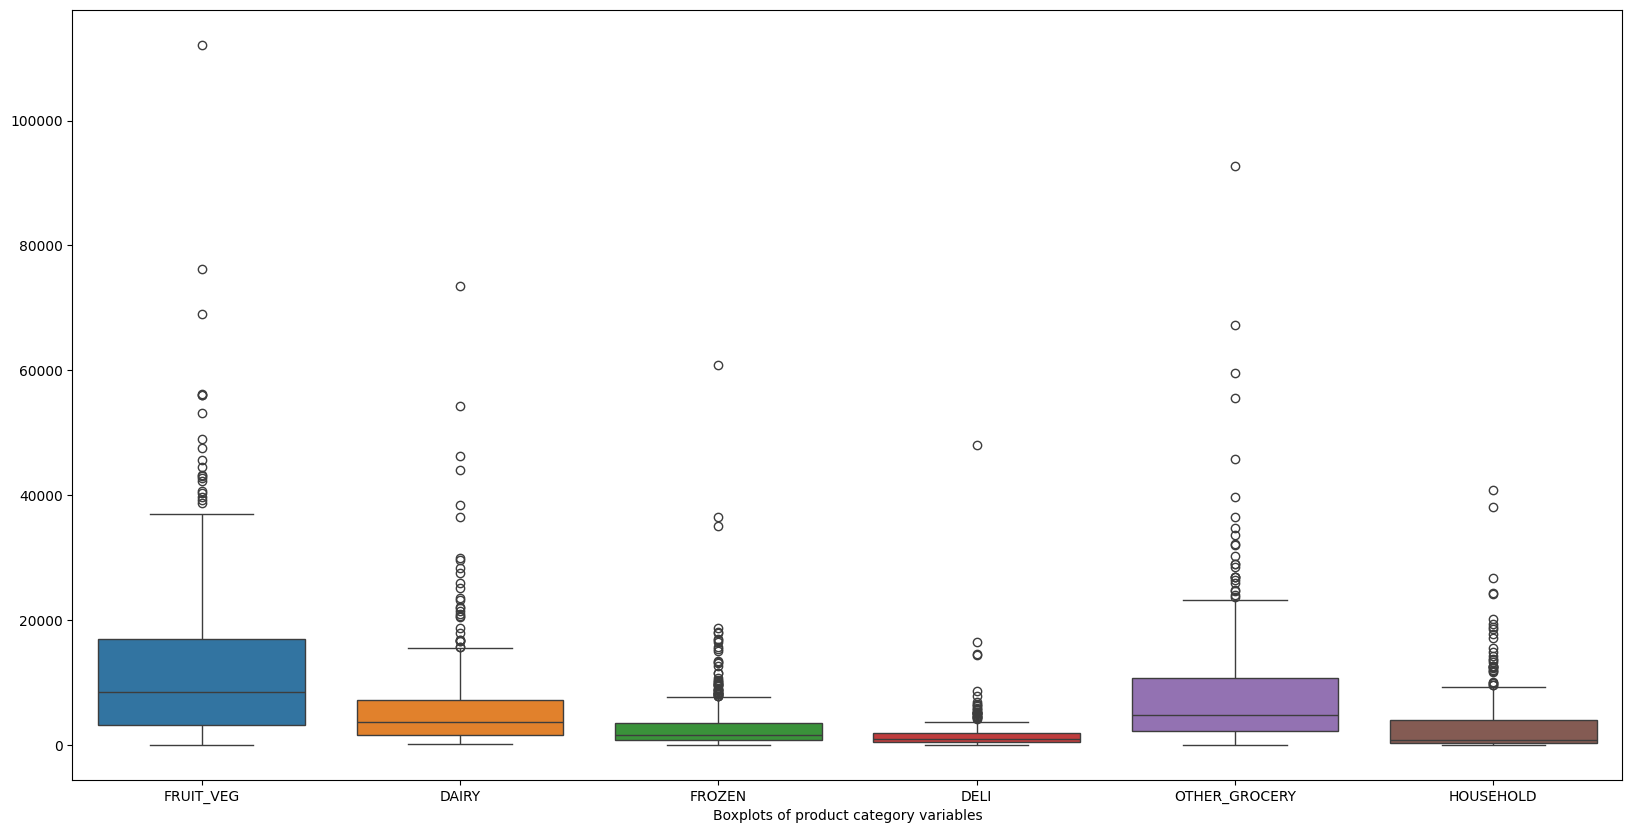

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax= plt.subplots(figsize=(20, 10))
boxplots= sns.boxplot(data = data)
plt.xlabel('Boxplots of product category variables')

You should now be used to first rapidly exploring the data through visualizations and code to understand how each feature is related to the others. We already know the categories we have to describe customers in, and can see their nature:

* FRUIT_VEG: annual spending on fresh fruit and vegetable products (Continuous)
* DAIRY: annual spending on all dairy related products (Continuous)
* FROZEN: annual spending on all frozen products (Continuous)
* DELI: annual spending on specialized delicatessen products (Continuous)
* OTHER_GROCERY: annual spending on all other grocery products (Continuous)
* HOUSEHOLD: annual spending on household (non-food) products (Continuous)

(Just in case you don't know a delicatessen counter is one that sells "cold cuts of meat, cheeses, and a variety of salads, as well as a selection of unusual or foreign prepared foods").

### Task 1b:
To get a better understanding of how variables relate to each other, let's create a scatter matrix of each of the six product categories present in the data in a single command.

Try the following code:


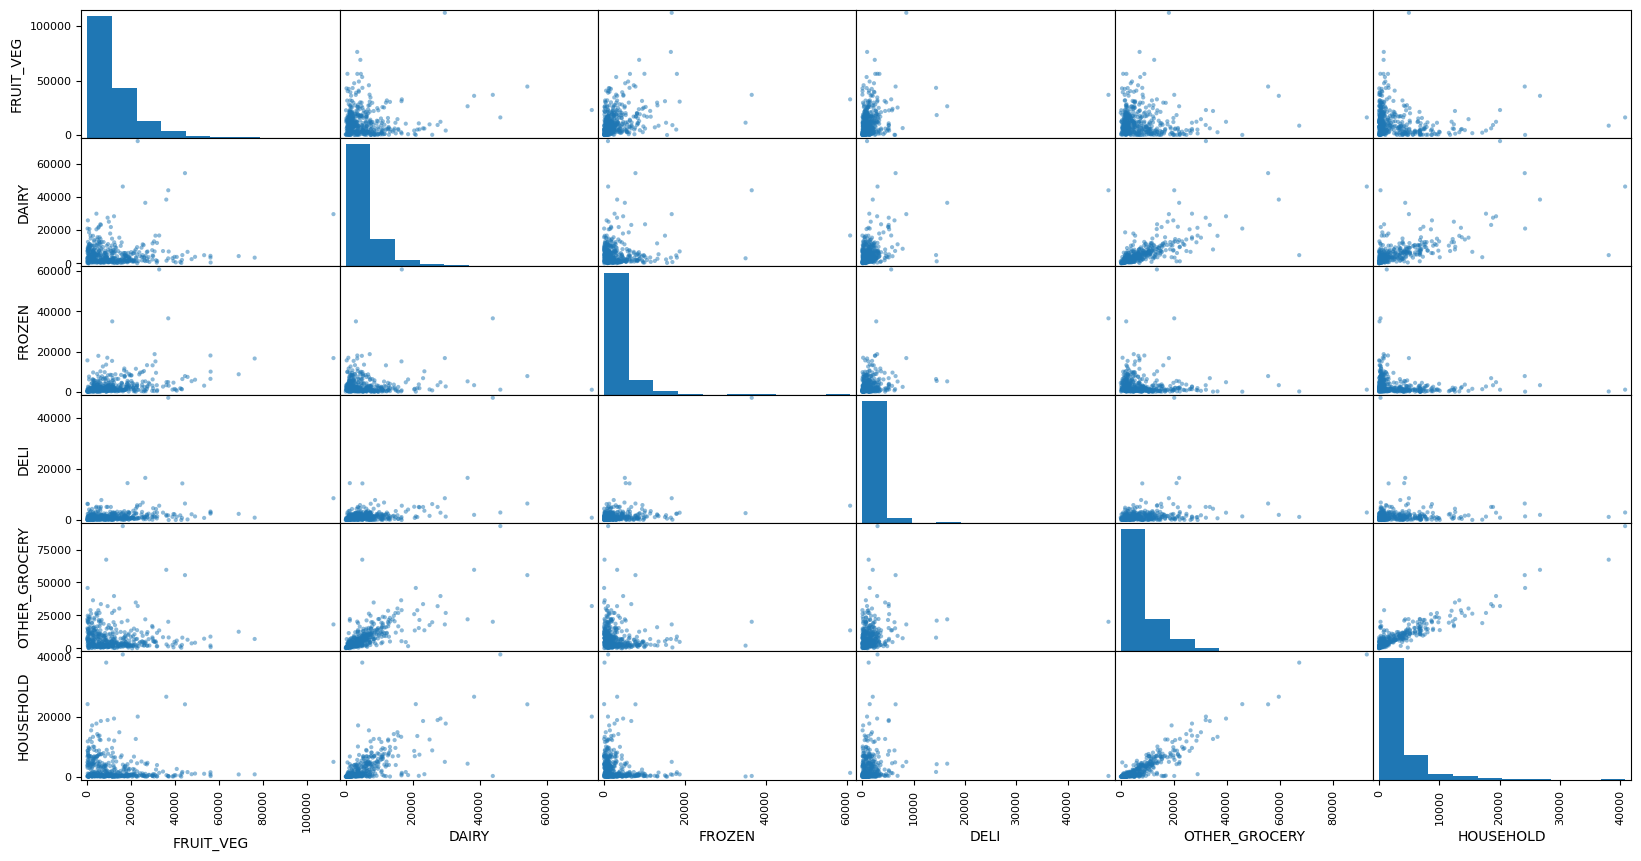

In [14]:
#-- Get a sense of them visually

#-- Produce a scatter matrix for each pair of features in the data
scatter = pd.plotting.scatter_matrix(data, figsize = (20,10))

The scatter matrix below may  show you potential correlations (which are a problem!) by eye.

### Task 1c:
**QUESTION** - Which pair of product categories are most highly related to each other?
> ANSWER - Other_grocery & Household, other_grocery & dairy

**QUESTION** - Is there any other product category which also seems paritally correlated with them?
> ANSWER - household & dairy

### Task 1d:
Let's check it using the corr() function that pandas provides to examine the Pearson correlations each product category has with each other:

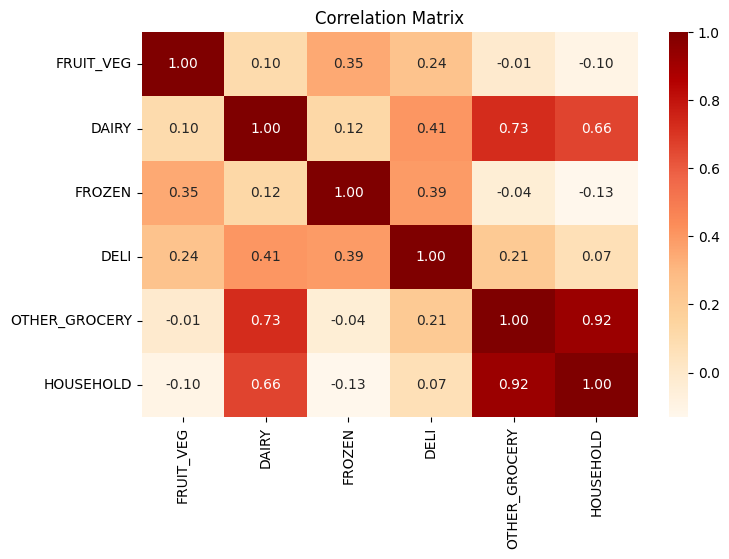

In [12]:
corr = data.corr(numeric_only = True)

plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap='OrRd', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Do the results correspond to what your saw in the scatterplots?

### Task 2a: Tidying up the different feature categories
This is actually fine for when we have 6 variables, but when we have more variables a visual heatmap is a useful shortcut to spotting categories which share the same information. Get a sense of these correlations visually using the the *heatmap* function from the seaborn library.

<span style="font-weight:bold; color:green;">&rarr; Run the following code, and check your results. Alter the colour map to something more attractive from https://matplotlib.org/examples/color/colormaps_reference.html <span/>

Text(0.5, 80.7222222222222, 'Market features correlations')

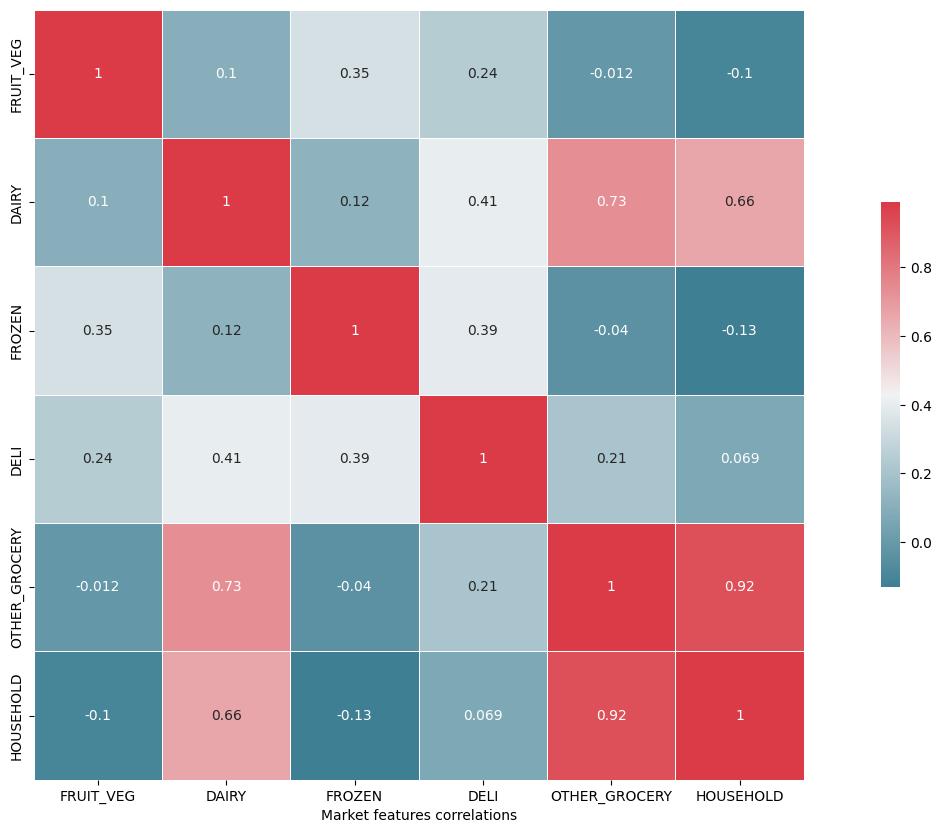

In [13]:
#-- Set up the figure
fig, ax= plt.subplots(figsize=(20, 10))

#-- Generate diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#-- Generate the heatmap
sns.heatmap(corr, cmap=cmap, vmax=.99, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot= True)
plt.xlabel('Market features correlations')

The fact that OTHER_GROCERY feature is strongly correlated with DAIRY and HOUSEHOLD indicates that it may redundant for summarizing customers' spending habits - the information it holds is already in HOUSEHOLD and DAIRY. We might want to do something about this, otherwise a customer segmentation might double count that information... and hence be skewed to separating customers on that dimension.


### Task 2b: Applying the log transform to make the data more "normal"

The other problem you may have noticed from the scatter plots is that very few product categories are "normally distributed".

Go back and check the diagonal of your scatterplot - you'll notice that there is a huge general skew to the left. It's actually worth us fixing this because (as you may recall) many clustering techniques seek to find "globular" clusters (especially k-means) - so people often pre-process the data so it looks more "normal".


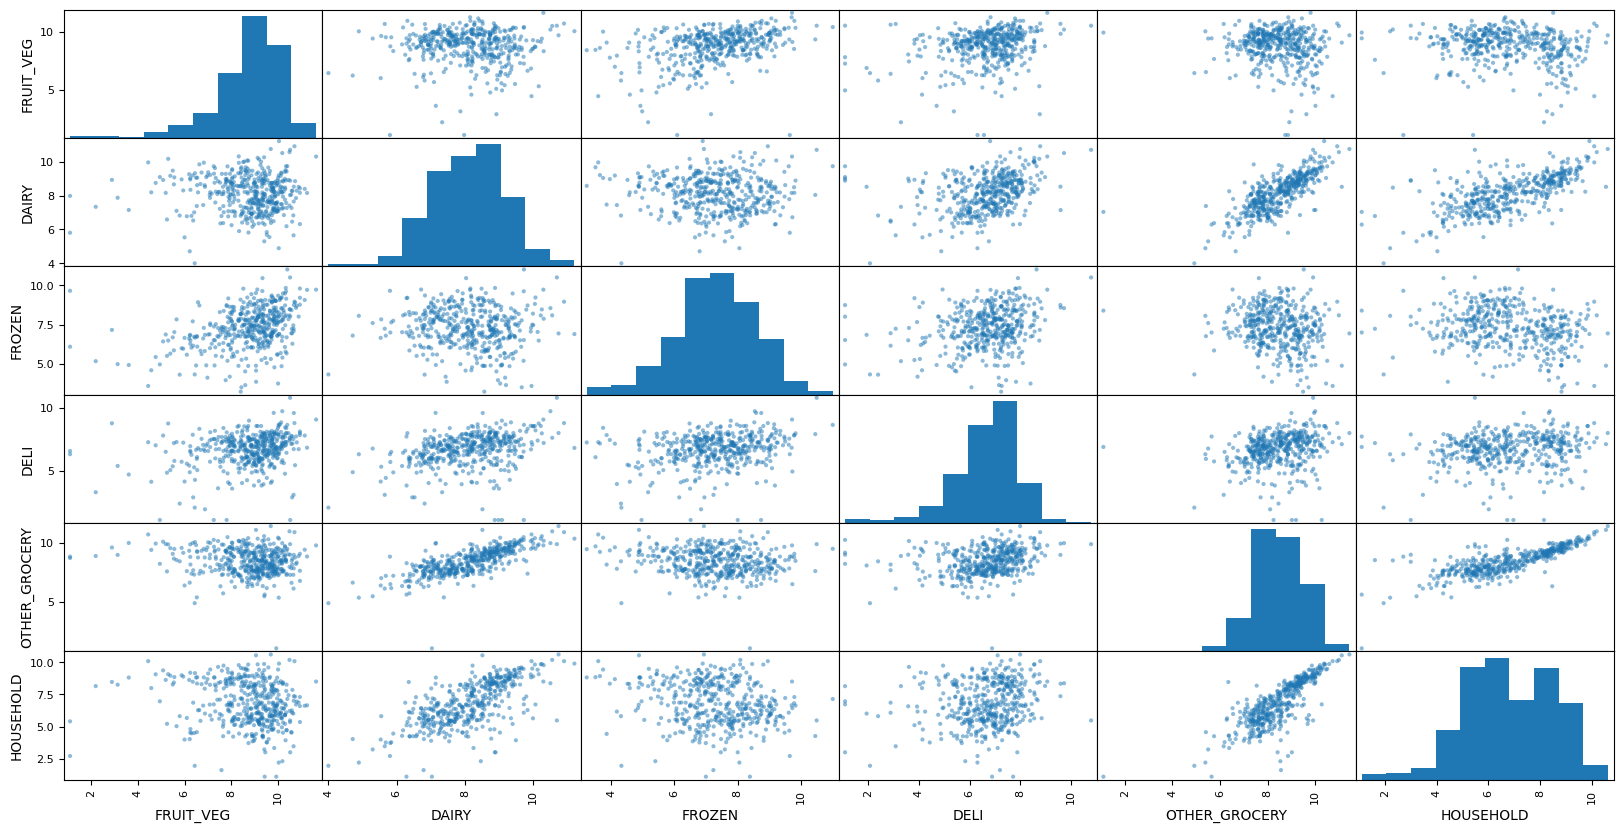

In [15]:
import numpy as np

# Scale the data using the natural logarithm
logged_data = np.log(data)

#-- Produce a scatter matrix using the logged data...
scatter = pd.plotting.scatter_matrix(logged_data, figsize = (20,10))

You'll hopefully have seen above that after applying a logarithm scaling to the data, the distribution of each feature appears much more normal. Take care here though - applying this transformation can change how much categories appear to correlate to each other. We'll continue using this data henceforth!


### Task 2c: Feature Engineering
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the customer data. Now you might think that we don't need to do this - why would we try and reduce dimensions when we only have 6 categories? This would be a necessary step if we were using raw product purchases, where we would have essentially thousands of categories.

The reason is we want to **eliminate the correlations** in our data as they will skew results towards partitioning customers based on those correlated variables. To do this, we could use a variety of techniques, but let's use PCA to begin with. Review last semester's lecture slides on PCA if you can't remember what it does.

In addition to helping eliminate correlated dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space. However, it is a composition of the original categories present in the data, so it will take some interpreting.

<span style="font-weight:bold; color:green;">&rarr; Run the following code, and analyse your results.<span/>

In [16]:
#!pip3 uninstall scikit-learn
#!pip3 install -U scikit-learn # un-comment this line if you haven't installed scikit-learn yet

import sklearn

from sklearn.decomposition import PCA

#-- Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(logged_data)


PCA(n_components=6)

             FRUIT_VEG     DAIRY    FROZEN      DELI  OTHER_GROCERY  HOUSEHOLD
Dimension 1   0.173717 -0.394463  0.172196 -0.149436      -0.454364  -0.745515
Dimension 2  -0.685136 -0.162399 -0.487691 -0.509709      -0.069379  -0.041912
Dimension 3  -0.673512  0.033068  0.284811  0.644597      -0.032183  -0.218244
Dimension 4  -0.214326  0.018558  0.806083 -0.513490       0.064487   0.190050
Dimension 5  -0.000822  0.722288 -0.036243 -0.195366       0.347993  -0.563665
Dimension 6  -0.029276  0.543035 -0.017448 -0.022832      -0.813908   0.202444
Explained variance of each component: [0.44237417 0.27657107 0.11617342 0.09617719 0.0457568  0.02294735]
Cumulative explained variance: [0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


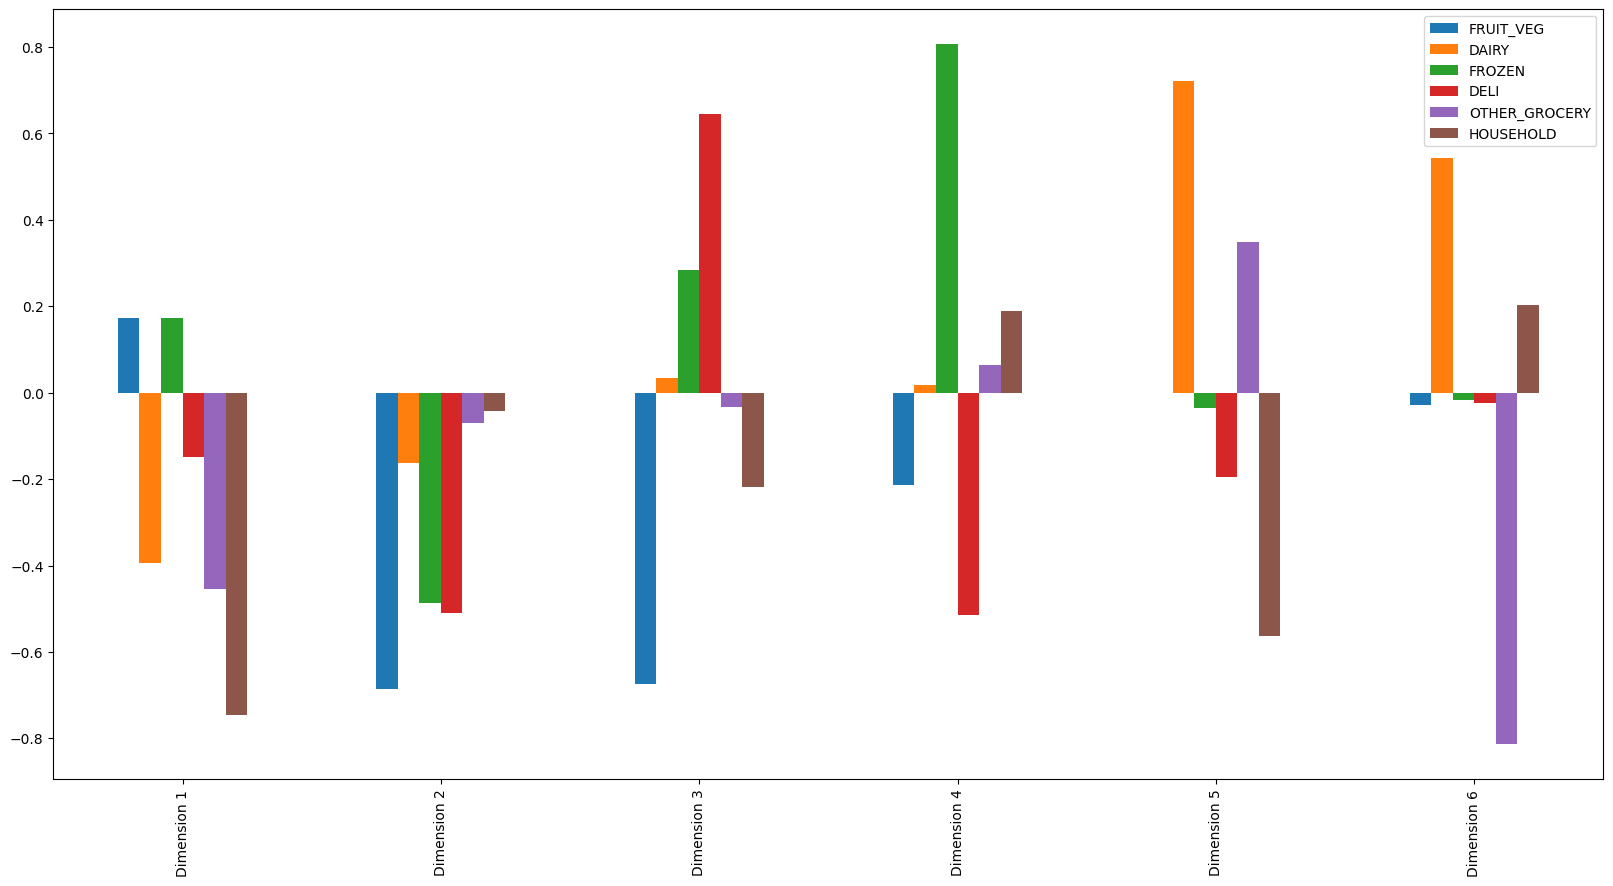

In [18]:
#-- Print out PCA results and try to interpret what each factor means
pca_results= pandas.DataFrame(data= pca.fit(logged_data).components_, columns= data.columns, index= ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5', 'Dimension 6'])
print(pca_results)

#-- Generate a PCA results bar plot
pca_results.plot.bar(figsize=(20, 10))

#-- Print out the explained variance of each component, as well as cumulatively
explained_variance = pca.explained_variance_ratio_
print('Explained variance of each component:', explained_variance)
print('Cumulative explained variance:', np.cumsum(explained_variance))

In [29]:
variance_first_second_pca = explained_variance[0] + explained_variance[1]
print(variance_first_second_pca)

variance_first_four_pca = sum(explained_variance[:4])
print(variance_first_four_pca)

0.7189452317370728
0.9312958450547781



<span style="font-weight:bold; color:green;">&rarr; How much variance in the data is explained in total by the first and second principal components? What about the first four principal components? <span/>


Hint: A positive increase in a specific dimension corresponds with an increase of the positive-weighted features and a decrease of the negative-weighted features. The rate of increase or decrease is based on the indivdual feature weights. And it doesn't matter which way up you flip a PCA dimension to your interpretation.

> Answer:
* 71.89 % of the variance in the data is explained by the first and second principal components.
* 93.12 % of the variance in the data is explained by the first four principal components.


### Task 2d: Interpreting potential Features

A key task in the real world when analysing the results of factorization, is to interpret what each new dimension means to the real world. Your task is as follows:

<span style="font-weight:bold; color:green;">&rarr;
Using the graph you've created above, create a short description of what you think each of the first three dimensions resulting from PCA **mean**, and give each one a descriptive name of your choice to add further analysis.<span/>

> Answer:

>**The first principal component (PC1):**
> ???

>**The second principal component (PC2):**
> ???

>**The third principal component (PC3)**
> ???


In [ ]:
What was your answer?

Alternatively, you might want to explore another type of factorization - Non-negative Matrix Factorization (NMF). You'll notice that unlike PCA, NMF has positive weights associated with each resulting factor. This non-negativity makes the resulting matrices easier to inspect.

--> Run the following code, and analyse your results.

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


<Axes: >

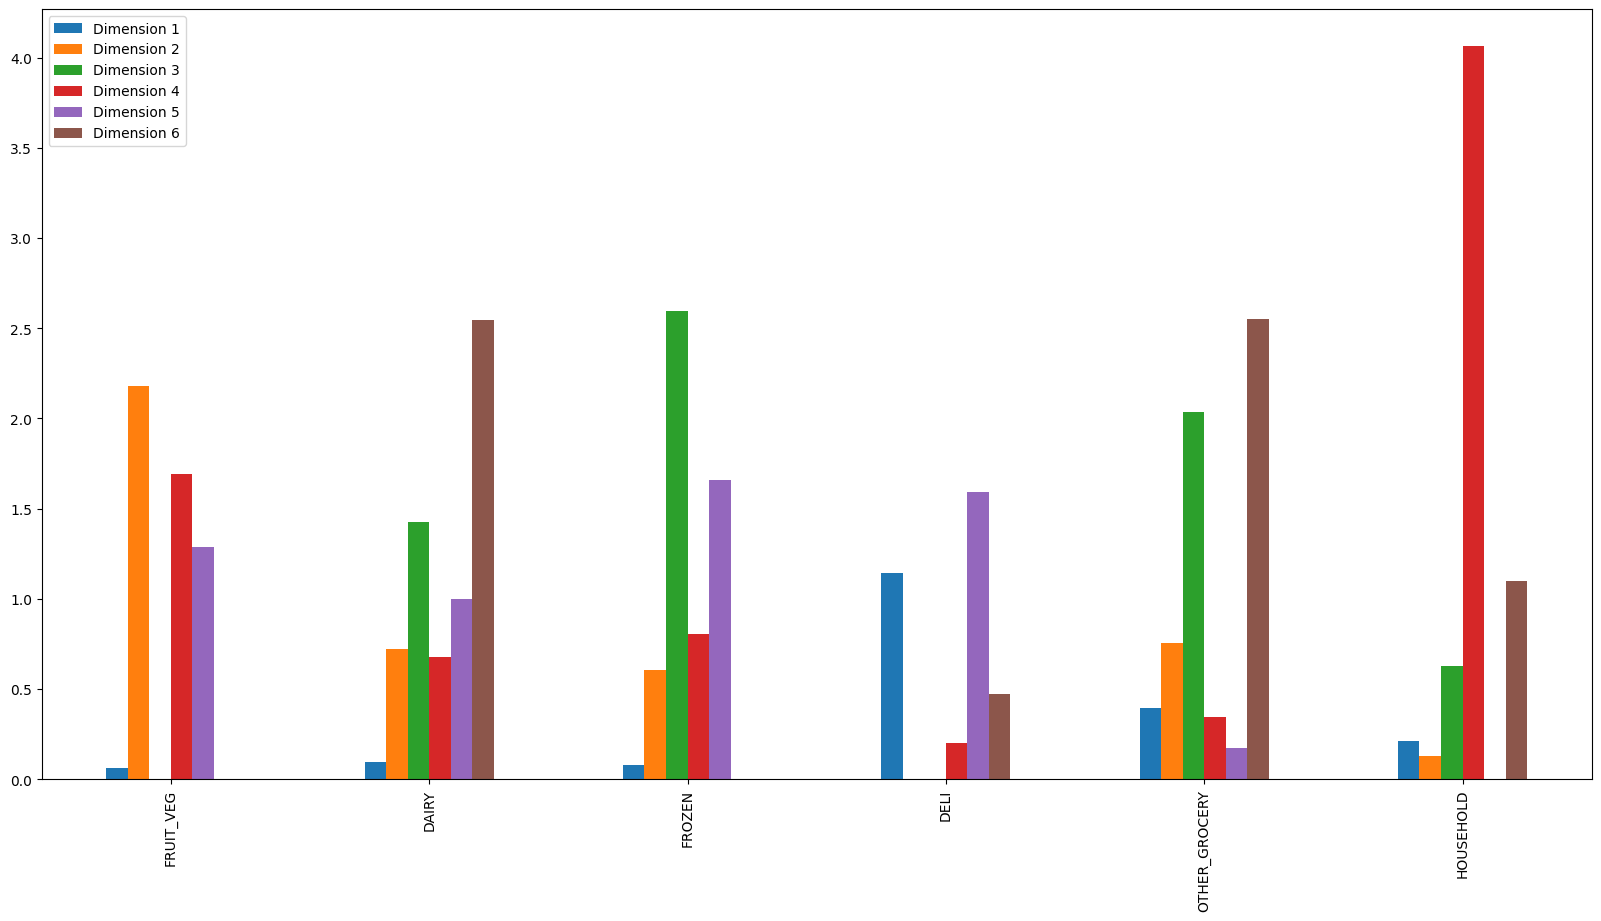

In [31]:
#-- Apply NMF by fitting the good data with with the same number of dimensions as features
from sklearn.decomposition import NMF

#-- Instantiate
nmf= NMF(n_components=6, init='random', random_state=42)
nmf.fit(logged_data)

#-- Print out NMF results and try to interpret what each factor means
nmf_results= pd.DataFrame(data = (nmf.fit(logged_data).components_.T), index= data.columns, columns= ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5', 'Dimension 6'])
#print(nmf_results)

#-- Generate an NMF results plot
nmf_results.plot.bar(figsize=(20, 10))


### Task 2e: Selecting our final Features

When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the cumulative explained variance ratio is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, we implement the following:

* We re-run PCA on our logged_data, so we only use the first two dimensions
* We apply a PCA transformation of good_data using pca.transform, and assign the results to reduced_data.


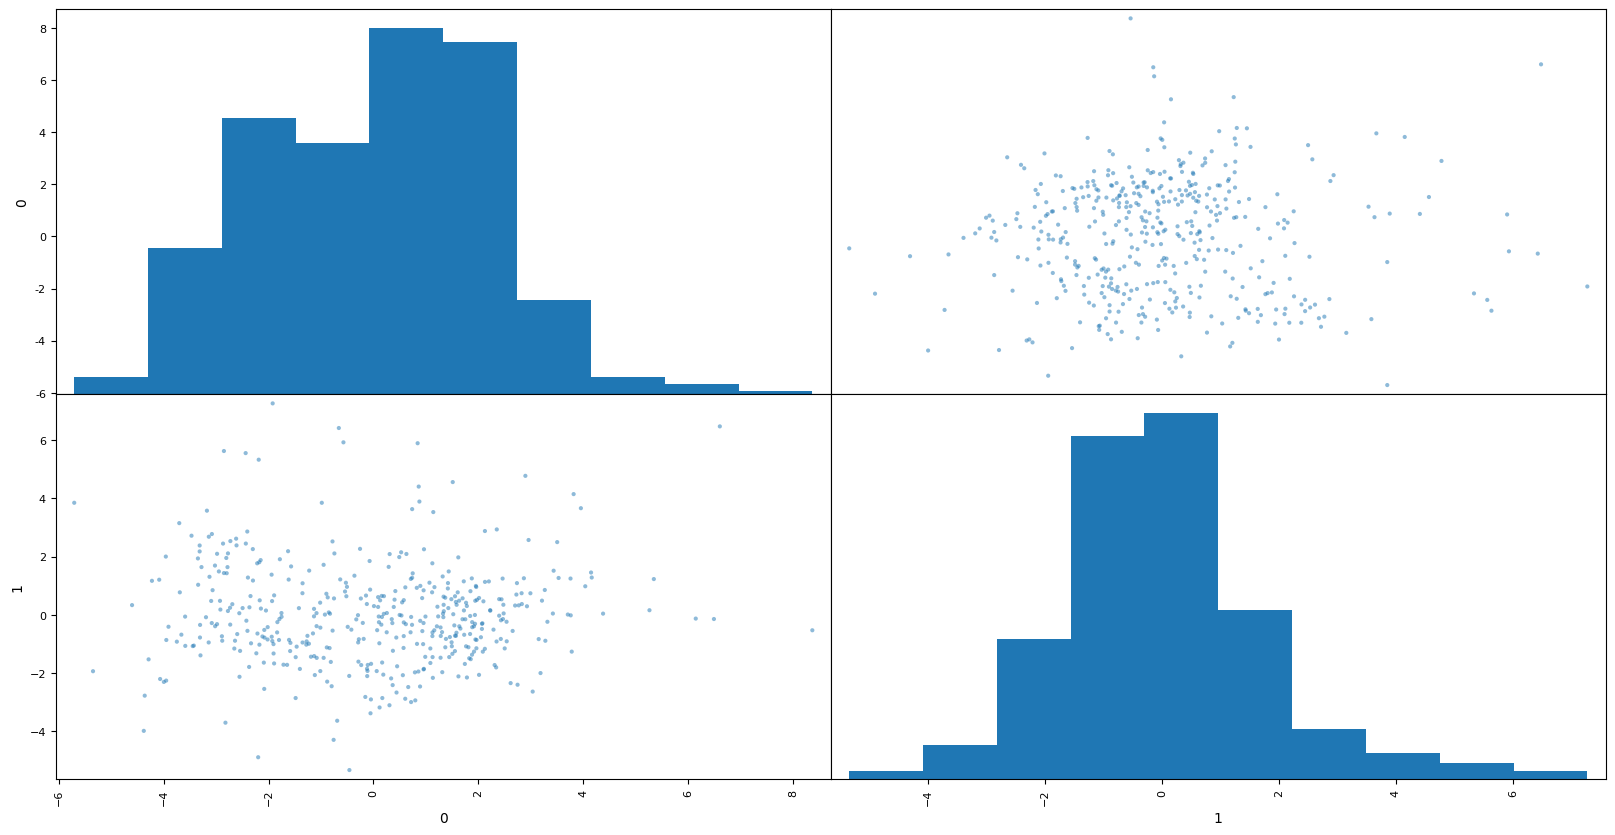

In [34]:
# TO DO: Apply PCA by fitting the good data with only two dimensions
# Instantiate
pca = PCA(n_components=2)
pca.fit(logged_data)

# TO DO: Transform the good data using the PCA fit above
reduced_data = pca.transform(logged_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data)
scatter = pd.plotting.scatter_matrix(reduced_data, figsize = (20,10))



### Task 3a: Clustering

In this section, we can finally create our segments. Let's use the K-Means clustering algorithm to identify the various customer segments hidden in the data. We will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. But how many segments do we want?

Depending on the business problem, the number of clusters that we expect to be in the data may already be known. However, when the number of clusters is not known a priori, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the mean silhouette coefficient provides a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:

* Fit a clustering algorithm to the reduced_data and assign it to clusterer.
* Predict the cluster for each data point in reduced_data using clusterer.predict and assign them to preds.
* Find the cluster centers using the algorithm's respective attribute and assign them to centers.
* Predict the cluster for each sample data point in pca_samples and assign them sample_preds.
* Import sklearn.metrics.silhouette_score and calculate the silhouette score of reduced_data against preds.
* Assign the silhouette score to score and print the result.


<span style="font-weight:bold; color:green;">&rarr; Task: complete the following code (using online documentation if necessary) to create a 3 segment solution. <span/>



In [35]:
#-- New  imports we will need
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#-- Create a clusterer that fits to 3 segments
k = 3
clusterer = KMeans(n_clusters=k)
clusterer.fit(logged_data)

#-- Predict the cluster for each data point
preds = clusterer.predict(logged_data)

#-- Calculate a silhouette score for the 3 segment solution
score = silhouette_score(logged_data, preds, metric='euclidean')
print("For n_clusters = {}. The average silhouette_score is : {})".format(k, score))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3. The average silhouette_score is : 0.2614258980841124)


In [36]:
#-- Create a clusterer that fits to 3 segments
k = 3
clusterer = KMeans(n_clusters=k)
clusterer.fit(reduced_data)

#-- Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

#-- Calculate a silhouette score for the 3 segment solution
score = silhouette_score(reduced_data, preds, metric='euclidean')
print("For n_clusters = {}. The average silhouette_score is : {})".format(k, score))

For n_clusters = 3. The average silhouette_score is : 0.3959752861312472)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Task 3b: Finding the right number of segments
This is fine, but let's search through a range of k from 2 through to 10 clusters to find out which has the best silhouette score.

<span style="font-weight:bold; color:green;">&rarr;  Task: complete the following code (using online documentation if necessary) to create a 3 segment solution. Create a loop that uses the above code to find silhouette scores for different values of k, from 2 though to 10 segments<span/>


In [ ]:
# Create range of clusters
???

# Loop through different k solutions and assess the silhouette socore
???


The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample. Therefore, it makes sense to use the same distance metric here as the one used in the clustering algorithm. Which has the highest score?

Let's pick that in lieu of any other knowledge of the business domain, as our ideal number for this example.


### Task 3c: Cluster Visualisation
Once you've chosen the optimal number of segments for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters.

<span style="font-weight:bold; color:green;">&rarr; Run the following visualization code, but add axis titles to the graph:</span>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


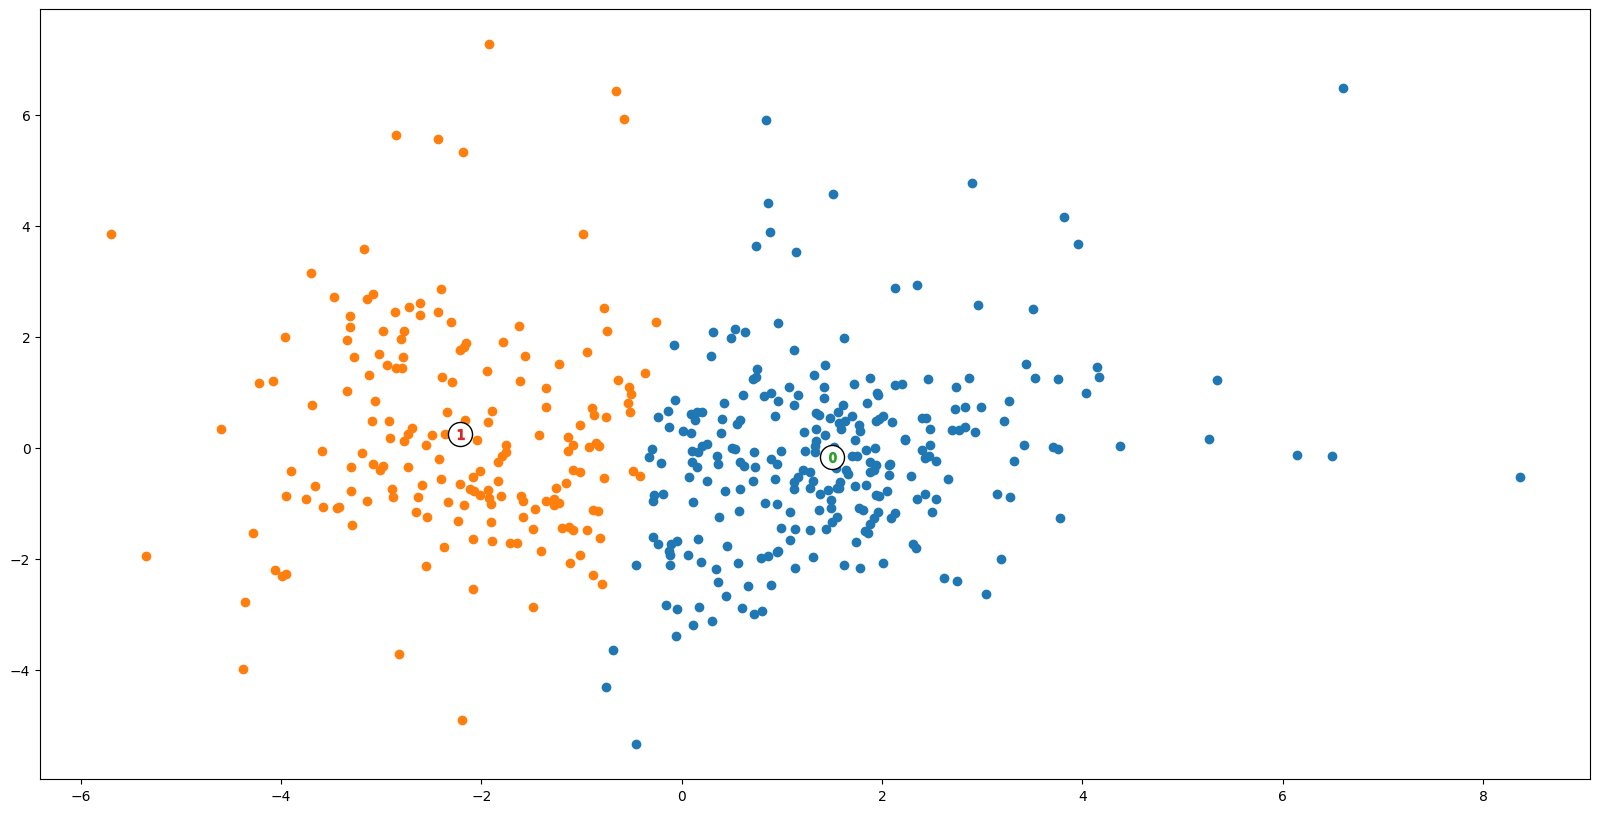

In [39]:
#-- Our final clustering solution
clusterer = KMeans(n_clusters=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centres = clusterer.cluster_centers_

#-- Put the predictions into a pandas dataframe format
assignments = pd.DataFrame(preds, columns = ['Cluster'])

#-- Put the predictions into a pandas dataframe format
plot_data = pd.concat([assignments, reduced_data], axis = 1)

#-- Color the points based on assigned cluster (n.b scatter will do this for us automatically)
plt.rcParams['figure.figsize'] = (20,10)

for i, c in plot_data.groupby('Cluster'):
    plt.scatter(c[0], c[1])

#-- Plot where the cluster centers are
for i, c in enumerate(centres):
    plt.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', marker = 'o', s=300);
    plt.scatter(x = c[0], y = c[1], marker='${}$'.format(i), alpha = 1, s=50);

Have a play around with this code, and examine what happens when we change k, before returning it to 2 segments.

Great. We have our segments. But what do they mean?

### Task 4a: Recovering Segment Archetypes in the original variables
Each cluster present in the visualization above has a central point. These centres (or means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's centre point corresponds to the average customer of that segment. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:

* Apply the inverse transform to centers using pca.inverse_transform and assign the new centers to log_centers.
* Apply the inverse function of np.log to log_centers using np.exp() and assign the true centers to true_centers.

<span style="font-weight:bold; color:green;">&rarr; Create the following code block to display our archetype profiles for each segment:</span>

In [40]:
# TO DO: Inverse transform the centres
log_centres = pca.inverse_transform(centres)

# TO DO: Exponentiate the centres
true_centres = np.exp(log_centres)

#-- Display the true centres
segments = ['Segment {}'.format(i) for i in range(0, len(centres))]
true_centres = pd.DataFrame(np.round(true_centres), columns = data.columns)
true_centres.index = segments
print(true_centres)

           FRUIT_VEG   DAIRY  FROZEN   DELI  OTHER_GROCERY  HOUSEHOLD
Segment 0     8994.0  1909.0  2081.0  681.0         2366.0      290.0
Segment 1     3570.0  7749.0   900.0  966.0        12463.0     4567.0


### Task 4b: Creating Profiles
One final step is required, and we are going to do this in groups - if we join our "predictions" dataframe which is telling us which people are in which cluster, with the original data, we can use summary statistics to analyse the data and create "profile" descriptions of what we think these entities are. Note that the means from these segments in the original space will be **different** (but related) to the centres in the clustering space, due to all the transformations we undertook.

Use **groupby()** and **describe()** to paint a picture of each cluster in the original space, compare that to your centroid results above. From these come up with a short description of each segment that could be used by the business, before we compare them to the reality.

> Hint: This is wholesale data providing different types of business outlets with the items they need to function.


In [47]:
#-- Join the segment assignments to the original data
final_assigments = pd.concat([assignments, data], axis = 1)

segment_1 = final_assigments[final_assigments.Cluster == 1]
segment_0 = final_assigments[final_assigments.Cluster == 0]
# print(segment_1.describe())
segments = [segment_1,segment_0]

for i in segments:
  print(i.describe())

#-- Create a loop that describes summary statistics for each segment
# for c, d in final_assigments.groupby('Cluster'):
#     print("Segment", c+1)
#     display(d.describe())

       Cluster      FRUIT_VEG         DAIRY        FROZEN          DELI  \
count    178.0     178.000000    178.000000    178.000000    178.000000   
mean       1.0    8605.651685   9972.252809   1580.539326   1772.882022   
std        0.0   11423.333014   9141.957121   1935.089668   2128.102816   
min        1.0       3.000000   1115.000000     25.000000      3.000000   
25%        1.0    2026.000000   5272.250000    419.000000    534.500000   
50%        1.0    5339.500000   7529.500000   1028.500000   1311.500000   
75%        1.0   11798.750000  11101.000000   1904.750000   2156.000000   
max        1.0  112151.000000  73498.000000  16745.000000  16523.000000   

       OTHER_GROCERY     HOUSEHOLD  
count     178.000000    178.000000  
mean    14823.404494   6428.938202  
std     11492.421673   5894.377892  
min      2824.000000    223.000000  
25%      8028.750000   2998.500000  
50%     11443.000000   4606.500000  
75%     18667.750000   7407.000000  
max     92780.000000  40827.